Window selection disabled: Processing all found 'Moving*.png' files.
Using minimum common shape: (100, 100)
Processing reference image for Real Image Radial Profile...
Reference image center detected at: (51, 47)

Processing 68 selected files...
Processing MovingBead-0_-35nm.png...
0.0015132427215576172
Processing MovingBead-0_-86nm.png...
0.0015132427215576172
Processing MovingBead-0_-123nm.png...
0.002524852752685547
Processing MovingBead-0_-167nm.png...
0.003519773483276367
Processing MovingBead-0_-214nm.png...
0.00451970100402832
Processing MovingBead-0_-260nm.png...
0.00451970100402832
Processing MovingBead-0_-298nm.png...
0.00451970100402832
Processing MovingBead-0_-348nm.png...
0.005522012710571289
Processing MovingBead-0_-388nm.png...
0.0065135955810546875
Processing MovingBead-0_-432nm.png...
0.0065135955810546875
Processing MovingBead-0_-476nm.png...
0.007513284683227539
Processing MovingBead-0_-518nm.png...
0.00851297378540039
Processing MovingBead-0_-559nm.png...
0.00851297

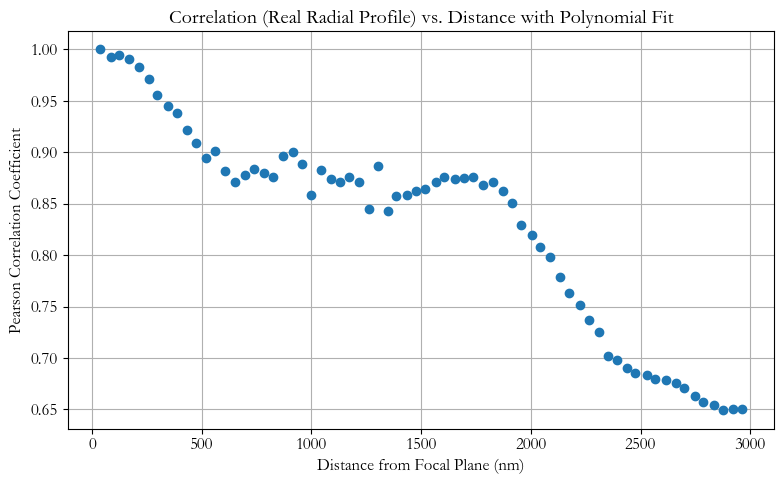


Script finished.


In [15]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Apr  6 11:12:08 2025

@author: yanjie
"""

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Mar 28 22:42:27 2025
Modified on Sun Apr 6 11:10:00 2025

@author: yanjie
"""

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from scipy.fft import fft2, fftshift
from scipy.stats import pearsonr
from scipy.ndimage import median_filter # Can be useful for noise reduction
import cv2 # OpenCV for image processing (contour detection, ellipse fitting)
import time

fft_corr_time = 0
fft_radial_corr_time = 0
real_radial_corr_time = 0

# --- Configuration ---

# Directory and filenames
base_path = r"D:\bead image\Beadimages\Beadimage1" # !!! UPDATE THIS PATH !!!
ref_filename = "MovingBead-0_-35nm.png" # Specify reference filename

# Analysis Method Selection
use_fft_radial_profile = False # Use radial profile of FFT magnitude
use_real_image_radial_profile = True # Use radial profile of real image intensity
# If both are False, it uses the 2D FFT correlation (original default)

# Data Selection
use_window_selection = False # Process only a window around the reference image (NEW)
window_size = 5             # Number of images before and after reference (if use_window_selection is True)

# High-pass filter threshold (for FFT methods)
fft_hp_threshold_ratio = 0.05

# Polynomial fit degree
poly_degree = 3

# Center Detection Parameters (for real image radial profile)
min_contour_area = 100 # Minimum pixel area to consider a contour as the bead

# --- Helper Functions ---

def extract_distance_and_filename(fname):
    """Extracts distance (nm) from filename using regex."""
    # Primary pattern: Moving...-123nm.png
    match = re.search(r'-(\d+)nm', fname)
    if match:
        distance = int(match.group(1))
        return fname, distance
    else:
        # Fallback pattern: Moving..._123nm.png (or similar with underscore)
        match_alt = re.search(r'_(\d+)nm', fname)
        if match_alt:
             distance = int(match_alt.group(1))
             return fname, distance
        print(f"Warning: Could not extract distance from filename: {fname}")
        return fname, None # Return None for distance if not found

def high_pass_filter(img_fft, threshold_ratio=0.05):
    """Applies a high-pass filter in frequency domain."""
    h, w = img_fft.shape
    cx, cy = w // 2, h // 2
    radius = int(min(cx, cy) * threshold_ratio)
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - cx) ** 2 + (Y - cy) ** 2)
    mask = dist_from_center >= radius
    return img_fft * mask

def compute_fft_radial_profile(image_fft_magnitude):
    """Computes radial profile from the magnitude of FFT."""
    h, w = image_fft_magnitude.shape
    center_y, center_x = h // 2, w // 2
    y, x = np.indices((h, w))
    r = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    r = r.astype(np.int32)
    tbin = np.bincount(r.ravel(), image_fft_magnitude.ravel())
    nr = np.bincount(r.ravel())
    radial_mean = np.divide(tbin, nr, out=np.zeros_like(tbin, dtype=float), where=nr!=0)
    return radial_mean

def background_subtract(img_array):
    """Subtracts background using median value."""
    background_value = np.median(img_array)
    subtracted = np.clip(img_array - background_value, 0, 255)
    return subtracted.astype(img_array.dtype)

def find_bead_center(img_array, min_area=100):
    """Finds the center of the largest circular object using contours."""
    img_blurred = cv2.medianBlur(img_array, 5)
    _, thresh = cv2.threshold(img_blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print("Warning: No contours found.")
        return None

    valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    if not valid_contours:
        print(f"Warning: No contours found with area > {min_area}.")
        return None

    largest_contour = max(valid_contours, key=cv2.contourArea)

    if len(largest_contour) < 5:
        print("Warning: Largest contour has less than 5 points, using moments for centroid.")
        M = cv2.moments(largest_contour)
        if M["m00"] == 0: return None
        center_x = int(M["m10"] / M["m00"])
        center_y = int(M["m01"] / M["m00"])
        return (center_x, center_y)
    else:
        try:
            ellipse = cv2.fitEllipse(largest_contour)
            center_x, center_y = map(int, ellipse[0])
            return (center_x, center_y)
        except cv2.error as e:
            print(f"Warning: cv2.fitEllipse failed: {e}. Using moments.")
            M = cv2.moments(largest_contour)
            if M["m00"] == 0: return None
            center_x = int(M["m10"] / M["m00"])
            center_y = int(M["m01"] / M["m00"])
            return (center_x, center_y)

def compute_real_radial_profile(img_array, center):
    """Computes radial profile from real image around a given center."""
    if center is None: return None
    h, w = img_array.shape
    center_y, center_x = center[1], center[0]
    if not (0 <= center_y < h and 0 <= center_x < w):
        print(f"Warning: Detected center {center} outside bounds ({w}x{h}). Using image center.")
        center_y, center_x = h // 2, w // 2

    y, x = np.indices((h, w))
    r = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    r = r.astype(np.int32)
    tbin = np.bincount(r.ravel(), img_array.ravel())
    nr = np.bincount(r.ravel())
    radial_mean = np.divide(tbin, nr, out=np.zeros_like(tbin, dtype=float), where=nr!=0)
    return radial_mean

# --- Main Script ---

# 1. Find and sort image files
if not os.path.isdir(base_path):
    raise FileNotFoundError(f"Base path directory not found: {base_path}")

# --- MODIFIED: Only include files starting with "Moving" ---
files = [
    f for f in os.listdir(base_path)
    if f.startswith("Moving") and f.endswith(".png")
]
if not files:
     raise FileNotFoundError(f"No 'Moving*.png' files found in {base_path}")

files_with_distances = [extract_distance_and_filename(f) for f in files]
files_with_distances = [
    (fname, distance) for fname, distance in files_with_distances if distance is not None
]
if not files_with_distances:
     raise ValueError("No 'Moving*.png' files with extractable distances found.")

files_with_distances.sort(key=lambda x: x[1]) # Sort by distance
sorted_files = [fname for fname, _ in files_with_distances] # extract sorted filenames

# 2. Select Files for Processing (Full list or Window)
files_to_process = []
if use_window_selection:
    print(f"Window selection enabled: Selecting +/- {window_size} images around {ref_filename}")
    try:
        ref_index = sorted_files.index(ref_filename)
    except ValueError:
        raise ValueError(f"Reference file '{ref_filename}' not found in the list of sorted 'Moving*.png' files.")

    # Calculate window boundaries safely
    start_index = max(ref_index - window_size, 0)
    end_index = min(ref_index + window_size + 1, len(sorted_files))
    files_to_process = sorted_files[start_index:end_index]
    print(f"Selected {len(files_to_process)} files for processing (indices {start_index} to {end_index-1}).")
else:
    print("Window selection disabled: Processing all found 'Moving*.png' files.")
    files_to_process = sorted_files # Process all files

if not files_to_process:
     raise ValueError("No files selected for processing. Check reference filename and window settings.")


# 3. Process Reference Image (Only if it's in the list to be processed)
ref_img_path = os.path.join(base_path, ref_filename)
if not os.path.exists(ref_img_path):
     # This check might be redundant if ref_index was found, but good practice
    raise FileNotFoundError(f"Reference image not found: {ref_img_path}")

# Load reference image once
ref_img_pil = Image.open(ref_img_path).convert("L")
ref_img_np = np.array(ref_img_pil)

# Determine minimum common shape across *all* original sorted files (to ensure consistency)
shapes = []
for fname in sorted_files: # Use original full list for shape calculation
    try:
        img_path = os.path.join(base_path, fname)
        with Image.open(img_path) as img:
            shapes.append(img.size[::-1])
    except Exception as e:
        print(f"Warning: Could not read shape for {fname}: {e}")
if not shapes: raise ValueError("Could not determine shapes for any image files.")
min_shape = (min(s[0] for s in shapes), min(s[1] for s in shapes))
print(f"Using minimum common shape: {min_shape}")

# Crop reference image
ref_img_cropped = ref_img_np[:min_shape[0], :min_shape[1]]

# Pre-calculate reference data based on selected method
ref_fft_filtered_abs_flat = None
ref_fft_radial_profile = None
ref_real_radial_profile = None
ref_processing_successful = True # Flag to track if ref data is valid

if use_real_image_radial_profile:
    print("Processing reference image for Real Image Radial Profile...")
    ref_bg_subtracted = background_subtract(ref_img_cropped)
    ref_center = find_bead_center(ref_bg_subtracted, min_area=min_contour_area)
    if ref_center:
        print(f"Reference image center detected at: {ref_center}")
        ref_real_radial_profile = compute_real_radial_profile(ref_bg_subtracted, ref_center)
        if ref_real_radial_profile is None:
             print("Warning: Failed to compute radial profile for reference image.")
             ref_processing_successful = False
    else:
        print("Warning: Failed to detect center for reference image.")
        ref_processing_successful = False

    if not ref_processing_successful:
        print("Cannot use Real Image Radial Profile method due to reference image processing failure.")
        # Exit or fallback logic could be added here if desired
        # For now, we'll let it fail later when correlation is attempted

elif use_fft_radial_profile: # Use elif since only one method active
    print("Processing reference image FFT for FFT Radial Profile...")
    ref_fft = fftshift(fft2(ref_img_cropped))
    ref_fft_filtered = high_pass_filter(ref_fft, threshold_ratio=fft_hp_threshold_ratio)
    ref_fft_filtered_abs = np.abs(ref_fft_filtered)
    ref_fft_radial_profile = compute_fft_radial_profile(ref_fft_filtered_abs)
    if ref_fft_radial_profile is None:
         print("Warning: Failed to compute FFT radial profile for reference image.")
         ref_processing_successful = False

else: # Default to 2D FFT correlation
    print("Processing reference image FFT for 2D Correlation...")
    ref_fft = fftshift(fft2(ref_img_cropped))
    ref_fft_filtered = high_pass_filter(ref_fft, threshold_ratio=fft_hp_threshold_ratio)
    ref_fft_filtered_abs = np.abs(ref_fft_filtered)
    ref_fft_filtered_abs_flat = ref_fft_filtered_abs.flatten()**1 # Using power 1 as before
    if ref_fft_filtered_abs_flat is None: # Should not happen unless FFT failed
        print("Warning: Failed to compute flattened FFT for reference image.")
        ref_processing_successful = False


# 4. Compute correlations for selected images
results = []
print(f"\nProcessing {len(files_to_process)} selected files...")
if not ref_processing_successful:
    print("Skipping correlation calculations because reference image processing failed.")
else:
    for fname in files_to_process:
        print(f"Processing {fname}...")
        # Extract distance again (could also store it earlier)
        distance_info = extract_distance_and_filename(fname)
        if distance_info is None or distance_info[1] is None:
            print(f"Skipping {fname} - could not re-extract distance.")
            continue
        distance = distance_info[1]

        try:
            img_path = os.path.join(base_path, fname)
            img_pil = Image.open(img_path).convert("L")
            img_np = np.array(img_pil)
            img_cropped = img_np[:min_shape[0], :min_shape[1]]

            r_value = np.nan # Default to NaN

            # --- Calculate correlation based on selected method ---
            if use_real_image_radial_profile:
                img_bg_subtracted = background_subtract(img_cropped)
                img_center = find_bead_center(img_bg_subtracted, min_area=min_contour_area)
                if img_center:
                    img_real_radial_profile = compute_real_radial_profile(img_bg_subtracted, img_center)
                    if img_real_radial_profile is not None and ref_real_radial_profile is not None:
                        min_len = min(len(ref_real_radial_profile), len(img_real_radial_profile))
                        if np.std(ref_real_radial_profile[:min_len]) > 1e-6 and np.std(img_real_radial_profile[:min_len]) > 1e-6:
                             start=time.time()
                             r_value, _ = pearsonr(ref_real_radial_profile[:min_len], img_real_radial_profile[:min_len])
                             real_radial_corr_time += time.time() - start
                             print(real_radial_corr_time)
                        else: print(f"Warn: Skipping {fname} correlation (zero variance in real profile).")
                    else: print(f"Skipping {fname} (failed compute real radial profile).")
                else: print(f"Skipping {fname} (failed detect center).")

            elif use_fft_radial_profile:
                img_fft = fftshift(fft2(img_cropped))
                img_fft_filtered = high_pass_filter(img_fft, threshold_ratio=fft_hp_threshold_ratio)
                img_fft_filtered_abs = np.abs(img_fft_filtered)
                img_fft_radial_profile = compute_fft_radial_profile(img_fft_filtered_abs)
                if img_fft_radial_profile is not None and ref_fft_radial_profile is not None:
                    min_len = min(len(ref_fft_radial_profile), len(img_fft_radial_profile))
                    if np.std(ref_fft_radial_profile[:min_len]) > 1e-6 and np.std(img_fft_radial_profile[:min_len]) > 1e-6:
                        start=time.time()
                        r_value, _ = pearsonr(ref_fft_radial_profile[:min_len], img_fft_radial_profile[:min_len])
                        fft_radial_corr_time += time.time() - start
                        print(fft_radial_corr_time)
                    else: print(f"Warn: Skipping {fname} correlation (zero variance in FFT profile).")
                else: print(f"Skipping {fname} (failed compute FFT radial profile).")

            else: # Default: 2D FFT correlation
                img_fft = fftshift(fft2(img_cropped))
                img_fft_filtered = high_pass_filter(img_fft, threshold_ratio=fft_hp_threshold_ratio)
                img_fft_filtered_abs_flat = np.abs(img_fft_filtered).flatten()**1
                if img_fft_filtered_abs_flat is not None and ref_fft_filtered_abs_flat is not None:
                    if np.std(ref_fft_filtered_abs_flat) > 1e-9 and np.std(img_fft_filtered_abs_flat) > 1e-9:
                         start=time.time()
                         r_value, _ = pearsonr(ref_fft_filtered_abs_flat, img_fft_filtered_abs_flat)
                         fft_corr_time += time.time() - start
                         print(fft_corr_time)
                    else: print(f"Warn: Skipping {fname} correlation (zero variance in 2D FFT).")
                else: print(f"Skipping {fname} (failed compute 2D FFT).")

            # --- Store result ---
            if not np.isnan(r_value):
                results.append((distance, r_value))
            else:
                print(f"Correlation calculation failed or was skipped for {fname}.")

        except Exception as e:
            print(f"Error processing file {fname}: {e}")

# 5. Sort, Save, Fit, and Plot Results
if not results:
    print("\nNo valid correlation results were computed. Cannot plot.")
else:
    results.sort(key=lambda x: x[0])
    df_results = pd.DataFrame(results, columns=["Distance (nm)", "Pearson r"])

    # --- Determine analysis method for title ---
    method_desc = "2D FFT"
    if use_real_image_radial_profile: method_desc = "Real Radial Profile"
    elif use_fft_radial_profile: method_desc = "FFT Radial Profile"
    plot_title = f"Correlation ({method_desc}) vs. Distance"
    if use_window_selection: plot_title += " (Windowed)"
    plot_title += " with Polynomial Fit"

    # --- Polynomial fit ---
    distances = df_results["Distance (nm)"].values
    correlations = df_results["Pearson r"].values
    fitted_correlations = None
    fit_label = f'Polynomial Fit (Degree {poly_degree})'
    if len(distances) > poly_degree:
        try:
            coeffs = np.polyfit(distances, correlations, poly_degree)
            polynomial_fit = np.poly1d(coeffs)
            fitted_correlations = polynomial_fit(distances)
        except (np.linalg.LinAlgError, ValueError) as fit_err:
             print(f"Warning: Polynomial fit failed: {fit_err}. Skipping fit.")
             fit_label = 'Polynomial Fit (Failed)'
    else:
        print(f"Warning: Not enough data points ({len(distances)}) for poly fit degree {poly_degree}. Skipping fit.")
        fit_label = 'Polynomial Fit (Skipped)'

    # --- Plot ---
    plt.figure(figsize=(8, 5))
    plt.plot(distances, correlations, 'o', label='Data Points')
    #if fitted_correlations is not None:
        #plt.plot(distances, fitted_correlations, '-', label=fit_label)

    plt.title(plot_title)
    plt.xlabel("Distance from Focal Plane (nm)")
    plt.ylabel("Pearson Correlation Coefficient")
    plt.grid(True)
    #plt.legend()
    plt.tight_layout()
    plt.show()

    # Optional: Save results to CSV
    # csv_save_path = os.path.join(base_path, "correlation_results_windowed.csv" if use_window_selection else "correlation_results_full.csv")
    # df_results.to_csv(csv_save_path, index=False)
    # print(f"Results saved to {csv_save_path}")

print("\nScript finished.")
